In [1]:
#Import all the needed libraries
import os
import pandas as pd
import numpy as np
import sys
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
# Import helper functions
# Define all the helping functions
####################################################
# Import packages
####################################################
import numpy as np
import copy
import pandas as pd
from plotnine import *


####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


def poly(x, degree=1):
    """
    Fit Polynomial
    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

# Predicting Fast Growth of Firms

# Data preparation

For my project I use data set from a set of firms in a certain European country (bisnode-firms dataset). I used a cleaned and prepared pannel data for 2010-2015 years and proceeded with it

In [3]:
# Load the data
data = pd.read_csv('cs_bisnode_panel.csv', delimiter = ',',dtype ='unicode')

In [4]:
#Checking what I imported
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034,2005-01-01,2005-12-31,NaN,692.59259033203125,7266.66650390625,7574.07421875,0,0,0,...,mix,Domestic,5630,56,3,1,Central,1990-11-19,NaN,NaN
1,1001034,2006-01-01,2006-12-31,NaN,603.70367431640625,13122.22265625,12211.111328125,0,0,0,...,mix,Domestic,5630,56,3,1,Central,1990-11-19,NaN,NaN
2,1001034,2007-01-01,2007-12-31,NaN,425.9259338378906,8196.2958984375,7800,0,0,0,...,mix,Domestic,5630,56,3,1,Central,1990-11-19,NaN,NaN
3,1001034,2008-01-01,2008-12-31,NaN,300,8485.185546875,7781.4814453125,0,0,0,...,mix,Domestic,5630,56,3,1,Central,1990-11-19,NaN,NaN
4,1001034,2009-01-01,2009-12-31,NaN,207.40740966796875,5137.037109375,15300,0,0,0,...,mix,Domestic,5630,56,3,1,Central,1990-11-19,NaN,0.0833333358168602


In [5]:
#Function to define table with missing values
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [6]:
missing_zero_values_table(data) #print table with missing values even though it is cleaned, just to check

Your selected dataframe has 48 columns and 287829 Rows.
There are 40 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
D,0,287829,100.0,287829,100.0,object
finished_prod,0,270344,93.9,270344,93.9,object
wages,0,269846,93.8,269846,93.8,object
COGS,0,269572,93.7,269572,93.7,object
net_dom_sales,0,269572,93.7,269572,93.7,object
net_exp_sales,0,269572,93.7,269572,93.7,object
exit_year,0,248970,86.5,248970,86.5,object
exit_date,0,231649,80.5,231649,80.5,object
labor_avg,0,146532,50.9,146532,50.9,object
birth_year,0,111818,38.8,111818,38.8,object


Even though initial data set was cleaned, I identified many missing values.Apparently, it isn't completely cleaned or I misunderstood smth from the task, so I went through cleaning procedures once again. 

First, I drop columns with many missing variables. Many I consider to be more than 30 percent

In [7]:
# To decide whether I need to drop any columns with missing values at all, I will visualize columns with biggest proportion of NAs
# Decision rule taken by me - if there are more than 30% NAs, I will drop a column
# Plotting columns where more than 5% values are missing
prop_na = data.isna().sum()/len(data)
prop_na_05 = prop_na[prop_na > .05]
prop_na_05 = prop_na_05.sort_values(0, ascending=True).reset_index()

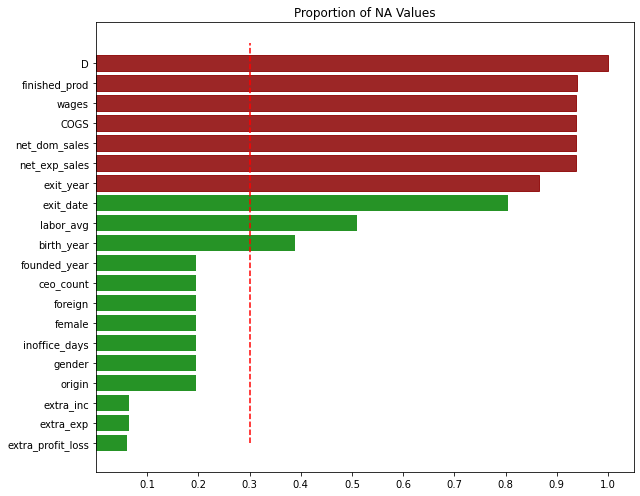

In [8]:
# Now plot on graph
plt.figure(figsize=(9, 7))

barh = plt.barh(prop_na_05['index'], prop_na_05[0], alpha=0.85, color='green')
for i in range(7):
    i += 1
    barh[-i].set_color('darkred')

plt.title('Proportion of NA Values')
plt.vlines(x=.3, ymin=0, ymax=20, color='red', linestyles='dashed')
plt.xticks(np.arange(.1, 1.01, .1))

plt.tight_layout()

In [9]:
# drop variables with many NAs
data = data.drop(columns = ['D','COGS', 'wages', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'exit_year', 'exit_date', 'labor_avg','birth_year' ])

In [10]:
missing_zero_values_table(data)

Your selected dataframe has 38 columns and 287829 Rows.
There are 30 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
founded_year,0,56457,19.6,56457,19.6,object
female,0,56427,19.6,56427,19.6,object
foreign,0,56427,19.6,56427,19.6,object
ceo_count,0,56427,19.6,56427,19.6,object
gender,0,56427,19.6,56427,19.6,object
origin,0,56427,19.6,56427,19.6,object
inoffice_days,0,56427,19.6,56427,19.6,object
extra_exp,0,18529,6.4,18529,6.4,object
extra_inc,0,18529,6.4,18529,6.4,object
extra_profit_loss,0,17203,6.0,17203,6.0,object


Others NA-s should be relaced. I took the decision to replace most of them with means. In some cases I had a thought of replacing with 0-s (for example, inventories, assets), but since they had the same number of missing values, I assumed it rather to some technical issues than the fact that they were 0. Some of the variables (like,  ceo and top executives count ) it didn't make to replace with mean since it would confuse the information, I replaced them with modes. 

In [11]:
data.ceo_count.describe() #ceo is also number of people top executives apparently - can't replace with mean

count     231402
unique        14
top            1
freq      179799
Name: ceo_count, dtype: object

In [12]:
data.region_m.describe() #look what is region_m variable since it is not in description

count      286989
unique          3
top       Central
freq       172906
Name: region_m, dtype: object

In [13]:
data.founded_date.describe() #that is a date variable- in fact i don't need it

count         287778
unique          6362
top       1991-12-30
freq             652
Name: founded_date, dtype: object

In [14]:
#First, all means replacements
data['foreign'] = data['foreign'].fillna(value=data['foreign'].mean) #can be replaced with mean since measueed in percent
data['female'] = data['female'].fillna(value=data['female'].mean) #can be replaced with mean since measueed in percent
data['foreign'] = data['foreign'].fillna(value=data['foreign'].mean) #can be replaced with mean since measueed in percent
data['inoffice_days'] = data['inoffice_days'].fillna(value=data['inoffice_days'].mean)
data['extra_exp'] = data['extra_exp'].fillna(value=data['extra_exp'].mean)
data['extra_inc'] = data['extra_inc'].fillna(value=data['extra_inc'].mean)
data['extra_profit_loss'] = data['extra_profit_loss'].fillna(value=data['extra_profit_loss'].mean)
data['profit_loss_year'] = data['profit_loss_year'].fillna(value=data['profit_loss_year'].mean)
data['amort'] = data['amort'].fillna(value=data['amort'].mean)
data['material_exp'] = data['material_exp'].fillna(value=data['material_exp'].mean)
data['personnel_exp'] = data['personnel_exp'].fillna(value=data['personnel_exp'].mean)
data['sales'] = data['sales'].fillna(value=data['sales'].mean)
data['inc_bef_tax'] = data['inc_bef_tax'].fillna(value=data['inc_bef_tax'].mean)
data['tang_assets'] = data['tang_assets'].fillna(value=data['tang_assets'].mean)
data['intang_assets'] = data['intang_assets'].fillna(value=data['intang_assets'].mean)
data['share_eq'] = data['share_eq'].fillna(value=data['share_eq'].mean)
data['subscribed_cap'] = data['subscribed_cap'].fillna(value=data['subscribed_cap'].mean)
data['curr_assets'] = data['curr_assets'].fillna(value=data['curr_assets'].mean)
data['liq_assets'] = data['liq_assets'].fillna(value=data['liq_assets'].mean)
data['inventories'] = data['inventories'].fillna(value=data['inventories'].mean)
data['fixed_assets'] = data['fixed_assets'].fillna(value=data['fixed_assets'].mean)
data['curr_liab'] = data['curr_liab'].fillna(value=data['curr_liab'].mean)


In [15]:
# Drop not needed columns
data = data.drop(columns = ['ind', 'nace_main', 'founded_date'])

In [16]:
missing_zero_values_table(data)

Your selected dataframe has 35 columns and 287829 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
founded_year,0,56457,19.6,56457,19.6,object
ceo_count,0,56427,19.6,56427,19.6,object
gender,0,56427,19.6,56427,19.6,object
origin,0,56427,19.6,56427,19.6,object
ind2,0,1038,0.4,1038,0.4,object
region_m,0,840,0.3,840,0.3,object


In [17]:
# Replacing the left columns with modes
data['founded_year'] = data['founded_year'].fillna(value=data['founded_year'].mode)
data['ceo_count'] = data['ceo_count'].fillna(value=data['ceo_count'].mode)
data['gender'] = data['gender'].fillna(value=data['gender'].mode)

data['origin'] = data['origin'].fillna(value=data['origin'].mode)
data['region_m'] = data['region_m'].fillna(value=data['region_m'].mode)

In [18]:
missing_zero_values_table(data)# great, no missing values now

Your selected dataframe has 35 columns and 287829 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
ind2,0,1038,0.4,1038,0.4,object


# Check duplicate values

In [19]:
data.shape #store df as a number of rows and columns

(287829, 35)

In [20]:
data = data.drop_duplicates() # drop duplicates

In [21]:
data.shape #there was no duplicated

(287829, 35)

# Labour and Feature engineering

In [22]:
# change some industry category codes

data['ind2'] = pd.to_numeric(data['ind2'], errors='coerce')
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [23]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       675
26.0     14877
27.0      9116
28.0     26098
29.0      4379
30.0      2499
32.0      1820
33.0     21839
35.0         6
40.0      2766
55.0     33756
56.0    165521
60.0      3439
99.0      1038
Name: comp_id, dtype: int64

In [24]:

# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan) 

In [25]:
data['sales'].describe() # see which format is sales


count     287829
unique     88515
top            0
freq       41862
Name: sales, dtype: object

In [26]:
data['sales'] = pd.to_numeric(data['sales'], errors='coerce')

In [27]:

data['sales'] = data['sales'].apply(lambda x: float(x)) #convert sales to float

In [28]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)

In [29]:
# I transform the format of variable sales
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log


In [30]:
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)

In [31]:
data["year"].describe() # look at year

count     556944
unique        12
top         2006
freq       46412
Name: year, dtype: object

In [32]:
data['year'] = pd.to_numeric(data['year'], errors='coerce') #change year to 
data['founded_year'] = pd.to_numeric(data['founded_year'], errors='coerce') #change year

In [33]:
# I create a variable depicting that firm is new
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [34]:

data['new'].describe()

count    556944.000000
mean          0.676677
std           0.467745
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

In [35]:
# Filter for firms with revenues between 1000 euro and 10 m euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")

In [36]:
data.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,region_m,ind2_cat,status_alive,default,ln_sales,sales_mil,sales_mil_log,d1_sales_mil_log,age,new
1,2005,100007469056,2005-01-01,2005-12-31,214.8148193359375,496.2962951660156,385.1851806640625,0,0,0,...,East,28.0,1,0,7.742273,0.002304,-6.073237,0.0,8.0,1.0
5,2005,10004676608,2005-01-01,2005-12-31,2718.5185546875,377.77777099609375,20411.111328125,66.66666412353516,285.1851806640625,218.51852416992187,...,East,40.0,1,0,9.469852,0.012963,-4.345659,0.0,NaN,1.0
7,2005,100062560256,2005-01-01,2005-12-31,837.03704833984375,28777.77734375,7751.85205078125,0,0,0,...,Central,33.0,1,0,10.664466,0.042807,-3.151044,0.0,10.0,1.0
10,2005,100094672896,2005-01-01,2005-12-31,8381.4814453125,12307.4072265625,10703.7041015625,1981.4814453125,0,-1981.4814453125,...,West,56.0,1,0,10.087043,0.024030,-3.728468,0.0,4.0,1.0
12,2005,1001034,2005-01-01,2005-12-31,692.59259033203125,7266.66650390625,7574.07421875,0,0,0,...,Central,56.0,1,0,11.046943,0.062752,-2.768567,0.0,15.0,1.0


In [37]:
data.year.describe

<bound method NDFrame.describe of 1         2005
5         2005
7         2005
10        2005
12        2005
          ... 
556916    2016
556919    2016
556923    2016
556929    2016
556933    2016
Name: year, Length: 227614, dtype: int64>

In [38]:
data.columns #look at columns

Index(['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'tang_assets', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'founded_year', 'ceo_count',
       'foreign', 'female', 'inoffice_days', 'gender', 'origin', 'ind2',
       'urban_m', 'region_m', 'ind2_cat', 'status_alive', 'default',
       'ln_sales', 'sales_mil', 'sales_mil_log', 'd1_sales_mil_log', 'age',
       'new'],
      dtype='object')

In [39]:
# I generate a target variable accounting for growth in the market. 
#data['growth_difference'] =data.groupby(['year', 'comp_id'])['ln_sales'].shift(-1)-data['ln_sales']

In [40]:
#  I create firm characteristics
data["age2"] = data["age"] ** 2 #square of age
data["gender_m"] = data["gender"].astype("category") #encode as categorical
data["m_region_loc"] = data["region_m"].astype("category")# encode as categorical

In [41]:
#convert to numeric to perform further operations
data[["intang_assets","curr_assets","fixed_assets", 'sales']] = \
    data[["intang_assets","curr_assets","fixed_assets",'sales']].apply(pd.to_numeric, errors='coerce')

In [42]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    227409
1.0       124
Name: comp_id, dtype: int64

In [43]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [44]:
# generate total assets
data["total_assets_bs"] = data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
data["total_assets_bs"].describe()

count    2.275330e+05
mean     4.091442e+05
std      2.839552e+07
min      0.000000e+00
25%      8.485185e+03
50%      2.885556e+04
75%      1.111222e+05
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [45]:
# Convert several others variables to numeric
data[['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']] = \
    data[['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']].apply(pd.to_numeric, errors='coerce')

In [46]:
# Convert several others variables to numeric
data[['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets']] = \
    data[['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets']].apply(pd.to_numeric, errors='coerce')

In [47]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [48]:
# divide all pl_names elements by sales and create new column for it
#that is scaling by sales for items related to profit and losses
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [49]:
# divide all bs_names elements by total_assets_bs and create new column for it
#that is scaline of balance sheet variables
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[[col + "_bs"]] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [50]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [51]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [52]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [53]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")

data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [54]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)

In [55]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

# Probaility Prediction of Fast Growth Firms

In [56]:
#Let's limit data set to 2012 and 2013 years. I will need it for target variable in the future
data = data.query('2012<= year <= 2013')

In [57]:
#Import all libraries
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [58]:
#Define helper functions
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)
def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)
def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

In [59]:
# DEfine variables sets
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [60]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)


m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)



Define target variable - fast growth. I made a desicion that my fast growth will be based on sales

In [61]:
#Let's define the growth which happened between 2012 and 2013 
data = data.reset_index().sort_values(['year'])
data = (
    data
    .assign(growth=data.groupby(['comp_id'])['sales'].transform(
        lambda group: group.pct_change()))
    .sort_index()
)

In [62]:
data.growth.describe

<bound method NDFrame.describe of 0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
43182     0.047550
43183     0.148909
43184    16.413301
43185     0.025641
43186    -0.084284
Name: growth, Length: 43187, dtype: float64>

Now I will create variable defining whether the growth was fast. I consider fast growth the growth in sales equal or more than 10 %

In [63]:
data['fast_g'] = ((data['growth'] >= 0.1)) * 1

In [64]:
data['fast_g'].describe

<bound method NDFrame.describe of 0        0
1        0
2        0
3        0
4        0
        ..
43182    0
43183    1
43184    1
43185    0
43186    0
Name: fast_g, Length: 43187, dtype: int32>

In [66]:
#Finally, I assign fast growth as target variable y
y = data['fast_g']

In [118]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]

X1 = pd.concat([basevars], axis=1)
# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat([data[["age", "age2", "new"]]], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Running models

In [119]:
# To avoid further complications, I deal with infinity and Nans 
X1 = X1.replace([np.inf, -np.inf], np.nan) #replace all infinities and nans - it turned out to be a problem later
X1 = X1.replace(np.nan, 0)
X2 = X2.replace([np.inf, -np.inf], np.nan)
X2 = X2.replace(np.nan, 0)
X3 = X3.replace([np.inf, -np.inf], np.nan)
X3 = X3.replace(np.nan, 0)
y = y.replace([np.inf, -np.inf], np.nan)
y = y.replace(np.nan, 0)

In [120]:
X1.shape #look at X1 shape 

(43187, 4)

In [121]:
X1.head

<bound method NDFrame.head of        sales_mil_log  sales_mil_log_sq  d1_sales_mil_log_mod  \
0          -6.725434         45.231459              0.000000   
1          -3.241065         10.504500             -0.265425   
2          -3.798198         14.426311              0.522071   
3          -2.528603          6.393834              0.021874   
4          -3.346604         11.199758             -0.245429   
...              ...               ...                   ...   
43182      -3.096576          9.588785              0.046454   
43183      -0.967574          0.936200              0.138813   
43184      -3.606310         13.005472              1.500000   
43185      -5.821566         33.890625              0.025318   
43186      -3.556812         12.650912             -0.088049   

       profit_loss_year_pl  
0                -1.000000  
1                -0.275395  
2                 0.046108  
3                -0.054137  
4                -0.171383  
...                    ... 

In [122]:
y.shape

(43187,)

I want to explore coefficients and marginal differences for all 3 these simple logistic regressions

In [137]:
#First model
glm_modelx1 = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  -0.1796
r2:  -0.2528
MAE:  0.1867
MSE:  0.1867
RMSE:  0.4321


In [138]:
coef_matrix(X1, glm_modelx1)

,variable,coefficient
0,sales_mil_log,0.010025
1,sales_mil_log_sq,-0.021060
2,d1_sales_mil_log_mod,2.130658
3,profit_loss_year_pl,0.440967
4,Intercept,-1.650036


In [139]:
mx1 = sm.Logit(y,sm.add_constant(X1)).fit().get_margeff()
mx1.summary()

Optimization terminated successfully.
         Current function value: 0.379350
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 fast_g
Method:                          dydx
At:                           overall
========================================================================================
                          dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
sales_mil_log            0.0012      0.002      0.489      0.624      -0.004       0.006
sales_mil_log_sq        -0.0025      0.000     -5.488      0.000      -0.003      -0.002
d1_sales_mil_log_mod     0.2482      0.003     92.873      0.000       0.243       0.253
profit_loss_year_pl      0.0514      0.006      8.862      0.000       0.040       0.063
========================================================================================
"""

In [140]:
#Check model X2
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.1786
r2:  -0.2525
MAE:  0.1867
MSE:  0.1867
RMSE:  0.432


In [141]:
coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,sales_mil_log,-0.001897
1,sales_mil_log_sq,-0.022166
2,d1_sales_mil_log_mod,2.190759
3,profit_loss_year_pl,0.519557
4,fixed_assets_bs,0.070651
5,share_eq_bs,-0.182550
6,curr_liab_bs,-0.201378
7,curr_liab_bs_flag_high,0.062763
8,curr_liab_bs_flag_error,-1.526066
9,age,0.019751


In [142]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
mx2.summary()


Optimization terminated successfully.
         Current function value: 0.377766
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 fast_g
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0002      0.002     -0.091      0.928      -0.005       0.005
sales_mil_log_sq           -0.0026      0.000     -5.713      0.000      -0.003      -0.002
d1_sales_mil_log_mod        0.2544      0.003     91.958      0.000       0.249       0.260
profit_loss_year_pl         0.0603      0.006      9.293      0.000       0.048       0.073
fixed_assets_bs             0.0082      0.005      1.580      0.114      -0.002       0.018
share_eq_bs                -0.0212      0.004     -5.126      0.000      -0.029      -0.013
curr_liab_bs               -0.0234      0.007     -3.149      0.002      -0.038      -0.009
curr_liab_bs_flag_high      0.0073      0.006      1.123      0.262      -0.005       0.020
curr_liab_bs_flag_error    -0.1772      0.132     -1.338      0.181      -0.437       0.082
age                         0.0023      0.000      9.254      0.000       0.002       0.003
===========================================================================================
"""

In [143]:
#Third model
glm_modelx3 = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X3, y)
regression_results(y, glm_modelx3.predict(X3))

explained_variance:  -0.1534
r2:  -0.1624
MAE:  0.1732
MSE:  0.1732
RMSE:  0.4162


In [144]:
coef_matrix(X3, glm_modelx3)

,variable,coefficient
0,sales_mil_log,-4.451166e-02
1,sales_mil_log_sq,-2.545033e-02
2,total_assets_bs,4.312850e-09
3,fixed_assets_bs,-5.648958e-03
4,liq_assets_bs,2.488119e-01
5,curr_assets_bs,-1.528578e-01
6,share_eq_bs,-7.220841e-02
7,subscribed_cap_bs,-2.396778e-02
8,intang_assets_bs,-3.444377e-01
9,extra_exp_pl,-1.549545e-01


In [145]:
mx3 = sm.Logit(y,sm.add_constant(X3)).fit().get_margeff()
mx3.summary()

         Current function value: 0.304148
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 fast_g
Method:                          dydx
At:                           overall
==============================================================================================
                                dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sales_mil_log                 -0.0044      0.002     -1.750      0.080      -0.009       0.001
sales_mil_log_sq              -0.0025      0.000     -5.484      0.000      -0.003      -0.002
total_assets_bs             4.281e-10   9.74e-10      0.439      0.660   -1.48e-09    2.34e-09
fixed_assets_bs                0.0150      0.036      0.414      0.679      -0.056       0.086
liq_assets_bs                  0.0241      0.007      3.451      0.001       0.010       0.038
curr_assets_bs                 0.0008      0.036      0.023      0.982      -0.070       0.072
share_eq_bs                   -0.0070      0.003     -2.603      0.009      -0.012      -0.002
subscribed_cap_bs             -0.0024      0.005     -0.448      0.655      -0.013       0.008
intang_assets_bs              -0.0119      0.053     -0.224      0.823      -0.116       0.092
extra_exp_pl                  -0.2082      0.191     -1.091      0.275      -0.582       0.166
extra_inc_pl                   0.1779      0.161      1.104      0.270      -0.138       0.494
extra_profit_loss_pl          -0.1783      0.160     -1.116      0.265      -0.492       0.135
inc_bef_tax_pl                 0.0088      0.018      0.483      0.629      -0.027       0.045
inventories_pl                 0.0015      0.010      0.150      0.881      -0.018       0.021
material_exp_pl               -0.0128      0.010     -1.311      0.190      -0.032       0.006
profit_loss_year_pl            0.0051      0.018      0.286      0.774      -0.030       0.040
personnel_exp_pl               0.0178      0.010      1.830      0.067      -0.001       0.037
d1_sales_mil_log_mod           0.9332      0.009    103.698      0.000       0.916       0.951
d1_sales_mil_log_mod_sq       -0.6171      0.009    -65.242      0.000      -0.636      -0.599
flag_low_d1_sales_mil_log      1.0619     81.617      0.013      0.990    -158.905     161.028
flag_high_d1_sales_mil_log     0.2413      0.011     21.317      0.000       0.219       0.263
age                           -0.0060      0.001     -6.282      0.000      -0.008      -0.004
age2                           0.0003   4.01e-05      6.381      0.000       0.000       0.000
new                           -0.0853      0.005    -16.742      0.000      -0.095      -0.075
==============================================================================================
"""

Creating test and hold out set

In [146]:
index_train, index_holdout = train_test_split(
    data.index.values, train_size=round(0.8 * len(data.index)), random_state=42
)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [147]:
print("Total")
print(data["default"].value_counts(normalize=True))
print("Train")
print(data.iloc[index_train]["default"].value_counts(normalize=True))
print("Holdout")
print(data.iloc[index_holdout]["default"].value_counts(normalize=True))

Total
0    0.805265
1    0.194735
Name: default, dtype: float64
Train
0    0.806194
1    0.193806
Name: default, dtype: float64
Holdout
0    0.801551
1    0.198449
Name: default, dtype: float64


In [148]:
#specify cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

# Train Logit Models with Cross Validation

In [149]:
# no regularisation needed so setting the paremeter to very high value
C_value_logit=[1e20]

In [150]:
# Train Logit Models ----------------------------------------------
logit_model_vars = [
    X1.iloc[index_train],
    X2.iloc[index_train],
    X3.iloc[index_train],
    
]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    logit_models["X" + str(i + 1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds["X" + str(i + 1)] = np.sqrt(
        -1 * (logit_models["X" + str(i + 1)].scores_[1])
    ).tolist()

Introducing 4th model - LASSO

In [157]:
#Logitvats for LASSO
logitvars = pd.concat([X3], axis=1)

In [158]:
#The LASSO logit
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(logitvars.iloc[index_train])
)
normalized_logitvars.columns = logitvars.columns

In [159]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [1 / (l * n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="accuracy",
    solver="liblinear",
    random_state=42,
)

In [160]:
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

In [161]:
#get Cv values
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000362,0.817945
1,0.046416,0.000779,0.813082
2,0.021544,0.001679,0.813893
3,0.010000,0.003618,0.818408
4,0.004642,0.007795,0.822287
5,0.002154,0.016793,0.823560
6,0.001000,0.036179,0.823965
7,0.000464,0.077946,0.825239
8,0.000215,0.167930,0.825702
9,0.000100,0.361795,0.825731


In [162]:
#find best lambda
best_lambda = cv_summary_lasso.sort_values("mean_cv_score", ascending=False).iloc[0, 0]

In [163]:
#Let's look for coefficient matrix for LASSO as well
coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,sales_mil_log,-0.057767
1,sales_mil_log_sq,-0.231832
2,total_assets_bs,0.000576
3,fixed_assets_bs,0.000000
4,liq_assets_bs,0.063535
5,curr_assets_bs,-0.030679
6,share_eq_bs,-0.055890
7,subscribed_cap_bs,-0.026836
8,intang_assets_bs,-0.006604
9,extra_exp_pl,-0.004822


In [164]:
# refit with negative brier score so we have RMSE values for the same cv split
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [165]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds["LASSO"] = np.sqrt(
            -1 * (logLasso_brier_fitted.scores_[1][:, i])
        ).tolist()

In [166]:
# For each model: average RMSE 
CV_RMSE = dict()

nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
   
for key in logit_models:
    if key != "LASSO":
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [167]:
# We have 4 models, (3 logit and the logit lasso). For each we have a RMSE.
# We pick our preferred model based on that. -----------------------------------------------
logit_summary1 = np.transpose(
    pd.DataFrame.from_dict([nvars, CV_RMSE], orient="columns")
)
logit_summary1.columns = ["Number of predictors", "CV RMSE"]

In [168]:
#Now plot
logit_summary1

,Number of predictors,CV RMSE
X1,4.0,0.352570
X2,10.0,0.351951
X3,24.0,0.338426
LASSO,20.0,0.322582


# Loss function and classification

Now I need to define a cost of false negative and false positive classification for LF

In [169]:
# Introduce loss function
# relative cost of of a false negative classification (as compared with a false positive classification)
FP = 10
FN = 2
cost = FN / FP
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum() / len(y_train)

In [170]:
# Draw ROC Curve and find optimal threshold with loss function --------------------------
# The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []
    if model_name != "LASSO":
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [171]:
logit_summary2 = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
logit_summary2["Threshold for Fold5"] = fold5_threshold.values()
logit_summary2["Avg expected loss"] = expected_loss_cv.values()
logit_summary2["Expected loss for Fold5"] = fold5_expected_loss.values()

In [172]:
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,1.655565,1.869946,0.363994,0.364399
1,X2,1.475819,1.875989,0.363821,0.364399
2,X3,1.388289,0.765278,0.363763,0.363531
3,LASSO,1.036614,0.830466,0.363647,0.364110


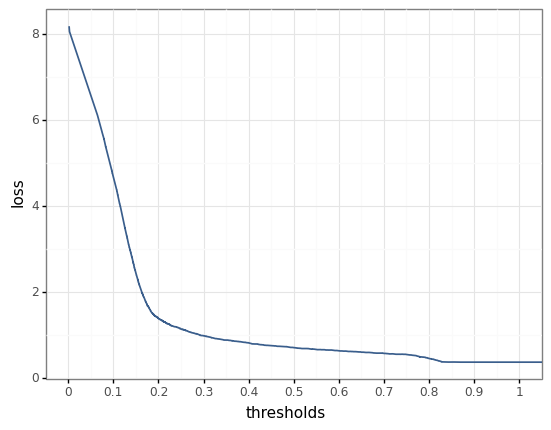

<ggplot: (100854501940)>

In [173]:
# Create loss plot based on Fold5 in CV ----------------------------------------------
# select model to plot
model_to_plot = "X1"
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

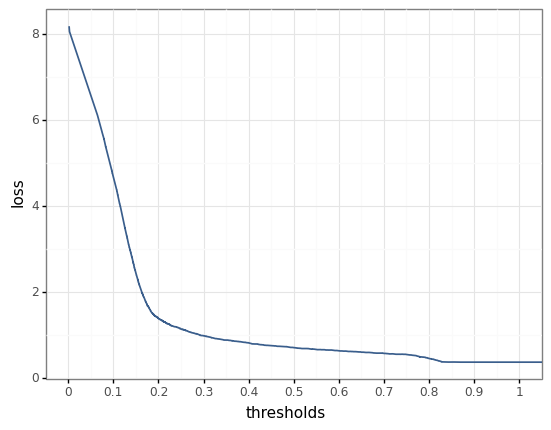

<ggplot: (100854540225)>

In [174]:
# Create loss plot based on Fold5 in CV ----------------------------------------------
# select model to plot
model_to_plot = "X1"
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

In [185]:

best_model = logit_models["X3"]
best_model_X_holdout = X3.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[
    :, 1
]
best_rmse_holdout = np.sqrt(
    metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout)
)
round(best_rmse_holdout, 3)

0.323

In [186]:
# Pick best model based on average expected loss ----------------------------------
# LASSO
best_logit_optimal_treshold = best_thresholds_cv["X3"]

# Get expected loss on holdout
holdout_treshold = np.where(
    logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.366

In [187]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actul no defaul,7057,0
Actual default,1580,0
